# TopoCluster Regression Rewrite

Here, we are going to write out our topo-cluster regression notebook. Let's start with charged pions, and see what we can do to understand them.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
plotpath = '/home/mswiatlowski/start_tf/caloml-atlas/regression/Plots_rewrite/'
modelpath_c = '/home/mswiatlowski/start_tf/caloml-atlas/classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [3]:
# import our resolution utilities

import sys
sys.path.append('/home/mswiatlowski/start_tf/caloml-atlas/')
from  util import resolution_util as ru

In [4]:
# import pi+- vs. pi0 images

path = '/fast_scratch/atlas_images/v6/'
pp = np.load(path+"piplus_full.npz")

npp = len(pp['EMB1'])

print("Number of pi+ events: {}".format(npp))

Number of pi+ events: 435489


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


<Figure size 432x288 with 0 Axes>

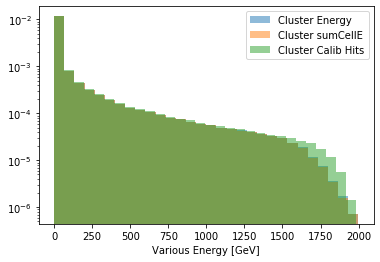

In [5]:
n_bins = 30
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pp['clusterE'], bins=n_bins, normed=True, alpha=0.5, label='Cluster Energy')
plt.hist(pp['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.5, label='Cluster sumCellE')
plt.hist(pp['cluster_ENG_CALIB_TOT'], bins=n_bins, normed=True, alpha=0.5, label='Cluster Calib Hits')
plt.yscale('log')
plt.xlabel('Various Energy [GeV]')
plt.legend()
plt.savefig(plotpath+'/hist_energy.pdf')
plt.show()

## Let's make some response plots now!

<Figure size 432x288 with 0 Axes>

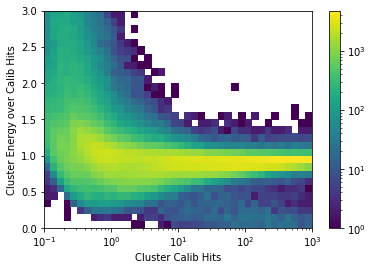

In [54]:
xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
hist2DCalib, x2DCalib, y2DCalib, blah = plt.hist2d(pp['cluster_ENG_CALIB_TOT'],pp['clusterE']/pp['cluster_ENG_CALIB_TOT'],bins=[xbin,ybin],norm=LogNorm())
# plt.hist(p0['clusterECalib']/p0['cluster_ENG_CALIB_TOT'], bins=n_bins, normed=True, alpha=0.5, label='$\pi^0$')
plt.xscale('log')
plt.ylim(0,3)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Energy over Calib Hits')
plt.colorbar()
# plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_ratio_pp.pdf')
plt.show()

Above, we can see the dip below 1 at 2-5 GeV, the rise to 1 above that, and the rise way above 1 below that. Interesting!

<Figure size 432x288 with 0 Axes>

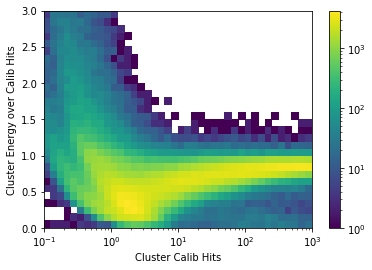

In [55]:
from matplotlib.colors import LogNorm

xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)

n_bins = 30
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist2d(pp['cluster_ENG_CALIB_TOT']+pp['cluster_ENG_CALIB_OUT_T']+pp['cluster_ENG_CALIB_DEAD_TOT'],pp['clusterE']/(pp['cluster_ENG_CALIB_TOT']+pp['cluster_ENG_CALIB_OUT_T']+pp['cluster_ENG_CALIB_DEAD_TOT']),bins=[xbin,ybin],norm=LogNorm())
# plt.hist(p0['clusterECalib']/p0['cluster_ENG_CALIB_TOT'], bins=n_bins, normed=True, alpha=0.5, label='$\pi^0$')
plt.xscale('log')
plt.ylim(0,3)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Energy over Calib Hits')
plt.colorbar()
# plt.legend()
plt.savefig(plotpath+'/hist_2D_calibfull_vs_ratio_pp.pdf')
plt.show()

Much more of a swoop notice down. But two populations? Potentially related to cases where a shower is fully contained in a cluster or not? Should return to this!

Here, let's see if I can make a profile plot function. 

In [56]:
from scipy.stats import binned_statistic
import scipy.stats as stats

In [57]:
profileX = stats.binned_statistic(pp['cluster_ENG_CALIB_TOT'],
                                        pp['clusterE']/pp['cluster_ENG_CALIB_TOT'],
                                        bins=xbin,statistic='mean').statistic

In [58]:
profileXMed = stats.binned_statistic(pp['cluster_ENG_CALIB_TOT'],
                                        pp['clusterE']/pp['cluster_ENG_CALIB_TOT'],
                                        bins=xbin,statistic='median').statistic

In [59]:
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

<Figure size 432x288 with 0 Axes>

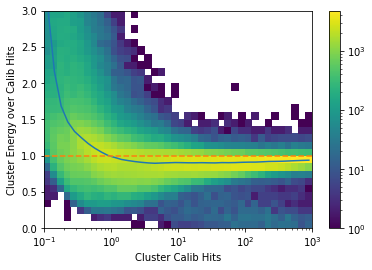

In [60]:
xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist2d(pp['cluster_ENG_CALIB_TOT'],pp['clusterE']/pp['cluster_ENG_CALIB_TOT'],bins=[xbin,ybin],norm=LogNorm())
plt.plot(xcenter, profileXMed)
plt.plot([0.1,1000],[1,1],linestyle='--')
plt.xscale('log')
plt.ylim(0,3)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Energy over Calib Hits')
plt.colorbar()
# plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_ratio_pp_profile.pdf')
plt.show()

This is what we wanted! Nice. Can see the shapes that we expect. Let's wrap this all into a function.

<Figure size 432x288 with 0 Axes>

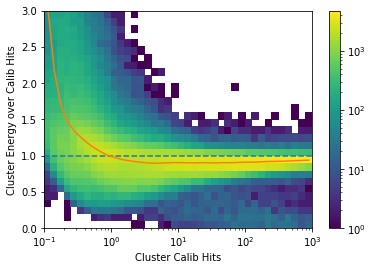

In [61]:
xcenter, medBase = ru.responsePlot(pp['cluster_ENG_CALIB_TOT'], pp['clusterE']/pp['cluster_ENG_CALIB_TOT'], name = plotpath+'hist_2D_calib_vs_ratio_pp_profile')

Let's see if I can get the profile with the other 2D plot we had seen before:

<Figure size 432x288 with 0 Axes>

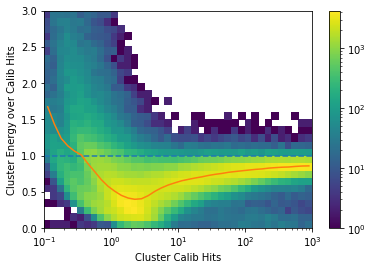

([0.11294627058970837,
  0.14219093021276402,
  0.17900777537149964,
  0.22535743732392294,
  0.2837082045838979,
  0.3571674682851675,
  0.44964720209038467,
  0.5660722890537326,
  0.7126427896022371,
  0.8971641173621403,
  1.1294627058970828,
  1.4219093021276392,
  1.7900777537149957,
  2.2535743732392284,
  2.837082045838977,
  3.5716746828516728,
  4.496472020903845,
  5.660722890537324,
  7.126427896022365,
  8.971641173621396,
  11.294627058970825,
  14.219093021276386,
  17.90077753714994,
  22.53574373239227,
  28.370820458389765,
  35.716746828516726,
  44.96472020903842,
  56.60722890537319,
  71.26427896022365,
  89.71641173621393,
  112.94627058970815,
  142.1909302127638,
  179.00777537149938,
  225.35743732392268,
  283.7082045838975,
  357.16746828516693,
  449.647202090384,
  566.0722890537315,
  712.6427896022358,
  897.1641173621388],
 array([1.67174639, 1.43138941, 1.23701544, 1.13301991, 1.0606989 ,
        1.00860311, 0.88838025, 0.77920204, 0.66689712, 0.575955

In [62]:
ru.responsePlot(pp['cluster_ENG_CALIB_TOT']+pp['cluster_ENG_CALIB_OUT_T']+pp['cluster_ENG_CALIB_DEAD_TOT'], 
                pp['clusterE']/(pp['cluster_ENG_CALIB_TOT']+pp['cluster_ENG_CALIB_OUT_T']+pp['cluster_ENG_CALIB_DEAD_TOT']),                                 
                name = plotpath + 'hist_2D_calibfull_vs_ratio_pp_profile')

We see it's way lower! Could it be that when the energy / true is very high in the previous plot, it's because "true" is missing energy outside the cluster or in the dead material? But the cluster itself shoudln't be picking that up. Weird.

## Let's implement the basic regression again!

In [6]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"])
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:1
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:2
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:3
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:4
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:5
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:6
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:7
INFO:tensorflow:Device is available but not used by distribute strategy: /device:GPU:1
INFO:te

In [0]:

from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

def baseline_model():
    regressor = Sequential()
    regressor.add(Dense(units=24, input_dim=1, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(units=24, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
    opt = Adam(lr=1e-4, decay=1e-6)
    regressor.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])

    return regressor

In [13]:
from keras.wrappers.scikit_learn import KerasRegressor

regressor = KerasRegressor(build_fn=baseline_model, batch_size=200*ngpu, epochs=50, verbose=1)
print(baseline_model().summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 24)                48        
_________________________________________________________________
dense_7 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 25        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
energy_pp = pp['clusterE']
calib_hits_pp = pp['cluster_ENG_CALIB_TOT']

energy_pp_l = np.log(energy_pp)
calib_hits_pp_l = np.log(calib_hits_pp)

In [10]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_epp = StandardScaler()
scalar_cal = StandardScaler()
# fit and transform in one step
standardized_energy_l = scaler_epp.fit_transform(energy_pp_l.reshape(-1,1))
standardized_calib_l  = scalar_cal.fit_transform(calib_hits_pp_l.reshape(-1,1))
# inverse transform
#inverse = scaler_epp.inverse_transform(standardized)

In [14]:
history_baseline = regressor.fit([standardized_energy_l], standardized_calib_l)

Epoch 1/50
435489/435489 [==============================] - 8s 19us/sample - loss: 0.3211 - mean_absolute_error: 0.3809 - mean_squared_error: 0.3211
Epoch 2/50
435489/435489 [==============================] - 8s 19us/sample - loss: 0.0378 - mean_absolute_error: 0.1299 - mean_squared_error: 0.0378
Epoch 3/50
435489/435489 [==============================] - 8s 18us/sample - loss: 0.0358 - mean_absolute_error: 0.1163 - mean_squared_error: 0.0358
Epoch 4/50
435489/435489 [==============================] - 8s 18us/sample - loss: 0.0355 - mean_absolute_error: 0.1132 - mean_squared_error: 0.0355
Epoch 5/50
435489/435489 [==============================] - 8s 19us/sample - loss: 0.0355 - mean_absolute_error: 0.1123 - mean_squared_error: 0.0355
Epoch 6/50
435489/435489 [==============================] - 8s 18us/sample - loss: 0.0354 - mean_absolute_error: 0.1122 - mean_squared_error: 0.0354
Epoch 7/50
435489/435489 [==============================] - 8s 18us/sample - loss: 0.0354 - mean_absolute_

In [15]:
predict_base_pp = np.exp(scalar_cal.inverse_transform(regressor.predict([standardized_energy_l])))

435489/435489 [==============================] - 1s 3us/sample


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

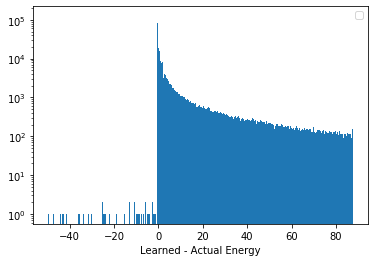

In [16]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(predict_base_pp-energy_pp,bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - Actual Energy')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

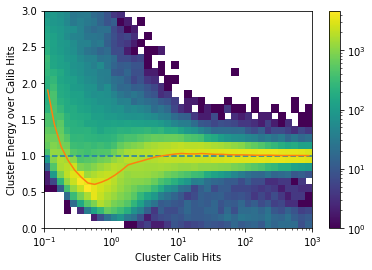

In [43]:
xcenter, medReg = ru.responsePlot(pp['cluster_ENG_CALIB_TOT'], predict_base_pp/pp['cluster_ENG_CALIB_TOT'],
                    plotpath+'hist_2D_calib_vs_baselineregratio_pp_profile',
                    'median')

Looking cool! One question: are we learning the mean, or median? We seem to be lowering things too much... to be understood!

<Figure size 432x288 with 0 Axes>

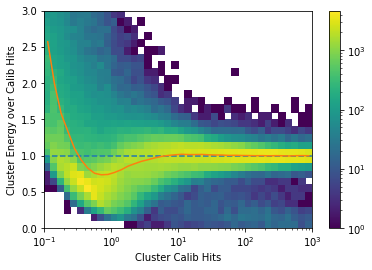

([0.11294627058970837,
  0.14219093021276402,
  0.17900777537149964,
  0.22535743732392294,
  0.2837082045838979,
  0.3571674682851675,
  0.44964720209038467,
  0.5660722890537326,
  0.7126427896022371,
  0.8971641173621403,
  1.1294627058970828,
  1.4219093021276392,
  1.7900777537149957,
  2.2535743732392284,
  2.837082045838977,
  3.5716746828516728,
  4.496472020903845,
  5.660722890537324,
  7.126427896022365,
  8.971641173621396,
  11.294627058970825,
  14.219093021276386,
  17.90077753714994,
  22.53574373239227,
  28.370820458389765,
  35.716746828516726,
  44.96472020903842,
  56.60722890537319,
  71.26427896022365,
  89.71641173621393,
  112.94627058970815,
  142.1909302127638,
  179.00777537149938,
  225.35743732392268,
  283.7082045838975,
  357.16746828516693,
  449.647202090384,
  566.0722890537315,
  712.6427896022358,
  897.1641173621388],
 array([2.5691931 , 1.993058  , 1.57880722, 1.33609581, 1.09639754,
        0.93854396, 0.82495017, 0.75471655, 0.73404261, 0.738891

In [18]:
ru.responsePlot(pp['cluster_ENG_CALIB_TOT'], predict_base_pp/pp['cluster_ENG_CALIB_TOT'],
                 'hist_2D_calib_vs_baselineregratio_pp_profile_mean',
                 'mean')

Weird! Worse at low, but the bump is less affected. High is fine.

## Now let's do resolution plots!

<Figure size 432x288 with 0 Axes>

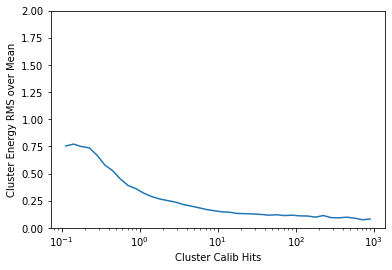

<Figure size 432x288 with 0 Axes>

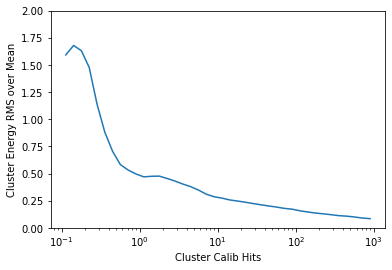

In [19]:
xcenter, stdOverMeanG = ru.resolutionPlot(pp['cluster_ENG_CALIB_TOT'], pp['clusterE']/pp['cluster_ENG_CALIB_TOT'],
                plotpath+'hist_2D_calib_vs_ratio_pp_stdMean', statistic='stdOverMean')
xcenter, iqrOverMedG = ru.resolutionPlot(pp['cluster_ENG_CALIB_TOT'], pp['clusterE']/pp['cluster_ENG_CALIB_TOT'],
                plotpath+'hist_2D_calib_vs_ratio_pp_iqrMed', statistic='iqrOverMed')

<Figure size 432x288 with 0 Axes>

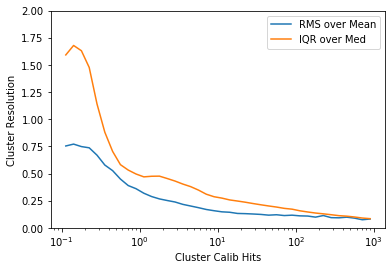

In [20]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(xcenter, stdOverMeanG, label = 'RMS over Mean')
plt.plot(xcenter, iqrOverMedG, label = 'IQR over Med')
plt.xscale('log')
plt.ylim(0,2)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Resolution')
plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_ratio_pp_several.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

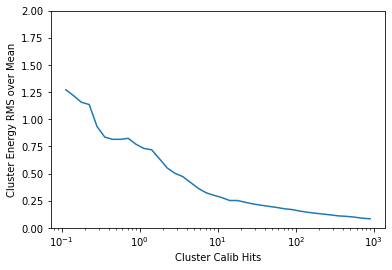

In [21]:
xcenter, iqrOverMedGReg = ru.resolutionPlot(pp['cluster_ENG_CALIB_TOT'], predict_base_pp/pp['cluster_ENG_CALIB_TOT'],
                plotpath+'hist_2D_calib_vs_baselineregratio_pp_iqrMed', statistic='iqrOverMed')

Now we can compare how we're doing with the original resolution, and the regressed one:

<Figure size 432x288 with 0 Axes>

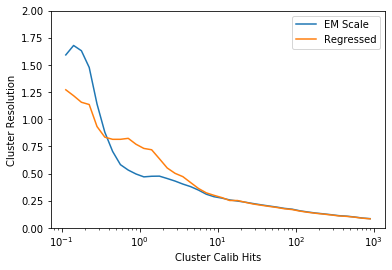

In [40]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(xcenter, iqrOverMedG, label = 'EM Scale')
plt.plot(xcenter, iqrOverMedGReg, label = 'Regressed')
plt.xscale('log')
plt.ylim(0,2)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Resolution')
plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_resolution_pp_EMvsReg.pdf')
plt.show()

That looks interesting. Some variation at low, probably due to the huge movements up/down we have. But later on, no improvement-- expected because we're only regressing on energy.

## Let's add one feature to the regressor

Just to keep it simple, we can make this the LC EM Probability, and see how we do

In [23]:
def baseline_wlc_model():
    regressor = Sequential()
    regressor.add(Dense(units=24, input_dim=2, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(units=24, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
    opt = Adam(lr=1e-4, decay=1e-6)
    regressor.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])

    return regressor

In [24]:

regressor_wlc = KerasRegressor(build_fn=baseline_wlc_model, batch_size=200*ngpu, epochs=100, verbose=1)
print(baseline_wlc_model().summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 24)                72        
_________________________________________________________________
dense_13 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 25        
Total params: 697
Trainable params: 697
Non-trainable params: 0
_________________________________________________________________
None


Will I have to normalize the LC EM prob? try without first. Ok that was really trash. Try again. Still trash! What the hecks. Do some exploring of the variable.

In [26]:
scaler_emprob = StandardScaler()

# fit and transform in one step
standardized_emprob = scaler_emprob.fit_transform(pp['cluster_EM_PROBABILITY'].reshape(-1,1))

In [ ]:
np.reshape(standardized_energy_l,len(standardized_energy_l))

<Figure size 432x288 with 0 Axes>

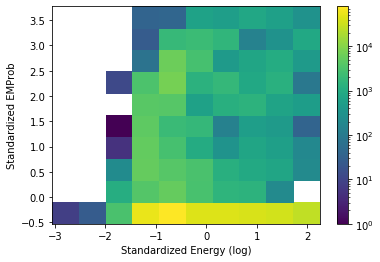

In [27]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist2d(np.reshape(standardized_energy_l,len(standardized_energy_l)),
            np.reshape(standardized_emprob, len(standardized_emprob)),norm=LogNorm())
# plt.plot(xcenter, profileXMed)
# plt.plot([0.1,1000],[1,1],linestyle='--')
# plt.xscale('log')
# plt.ylim(0,3)
plt.xlabel('Standardized Energy (log)')
plt.ylabel('Standardized EMProb')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

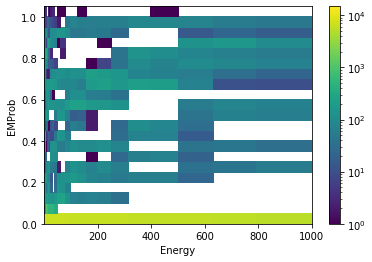

In [28]:
xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 1.1, 0.05)

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist2d(pp['clusterE'], pp['cluster_EM_PROBABILITY'],bins=[xbin, ybin], norm=LogNorm())
# plt.plot(xcenter, profileXMed)
# plt.plot([0.1,1000],[1,1],linestyle='--')
# plt.xscale('log')
# plt.ylim(0,3)
plt.xlabel('Energy')
plt.ylabel('EMProb')
plt.colorbar()
plt.show()

Ok, the above is probably why this isn't working... everything is close to 0!

In [103]:
#maninpulate and clean the EM probability. take 0 to epsilon.

emprob = pp['cluster_EM_PROBABILITY']
emprob_l = np.log(emprob)
#emprob_lc = emprob_l[~np.isinf(emprob_l)] This is not needed: let's replace 0 with an epsilon instead
eps = 0.000000000000000001
eps_len = len(np.where(emprob < eps)[0])
emprob_c = np.where(emprob<eps, eps, emprob)
emprob_lc = np.log(emprob_c)
bad = emprob_lc[np.isinf(emprob_lc)]
print(len(bad)) # this should be 0!

0
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [104]:
# ok, standardize the cleaned log
scaler_emprob_lc = StandardScaler()
# fit and transform in one step
standardized_emprob_lc = scaler_emprob_lc.fit_transform(emprob_lc.reshape(-1,1))

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

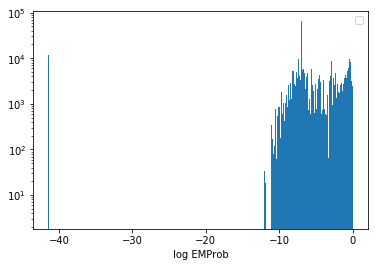

In [105]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(emprob_lc,bins = n_bins)
plt.yscale('log')
plt.xlabel('log EMProb')
plt.legend()
plt.show()

Train the regressor with the LC input here. Standardization of the emprob done above. Now we are also cleaning particularly bad cases.

In [110]:
input_wlc = np.column_stack((standardized_energy_l,standardized_emprob_lc))
# standardized_calib_lc = standardized_calib_l[~np.isinf(emprob_l)]

In [111]:
history_baseline_wlc = regressor_wlc.fit(input_wlc, standardized_calib_l)

Epoch 1/100
435489/435489 [==============================] - 9s 20us/sample - loss: 0.2987 - mean_absolute_error: 0.3605 - mean_squared_error: 0.2987
Epoch 2/100
435489/435489 [==============================] - 8s 19us/sample - loss: 0.0294 - mean_absolute_error: 0.1103 - mean_squared_error: 0.0294
Epoch 3/100
435489/435489 [==============================] - 8s 19us/sample - loss: 0.0272 - mean_absolute_error: 0.0975 - mean_squared_error: 0.0272
Epoch 4/100
435489/435489 [==============================] - 8s 19us/sample - loss: 0.0266 - mean_absolute_error: 0.0944 - mean_squared_error: 0.0266
Epoch 5/100
435489/435489 [==============================] - 8s 19us/sample - loss: 0.0264 - mean_absolute_error: 0.0935 - mean_squared_error: 0.0264
Epoch 6/100
435489/435489 [==============================] - 8s 19us/sample - loss: 0.0263 - mean_absolute_error: 0.0931 - mean_squared_error: 0.0263
Epoch 7/100
435489/435489 [==============================] - 8s 19us/sample - loss: 0.0262 - mean_ab

In [112]:
predict_base_wlc_pp = np.exp(scalar_cal.inverse_transform(regressor_wlc.predict(input_wlc)))

435489/435489 [==============================] - 2s 4us/sample


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

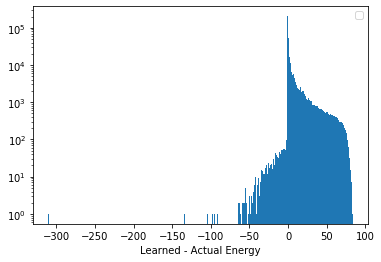

In [113]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(predict_base_wlc_pp-energy_pp,bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - Actual Energy')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

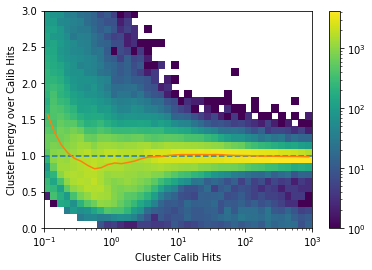

In [115]:
xcenter, medRegwLC = ru.responsePlot(pp['cluster_ENG_CALIB_TOT'], predict_base_wlc_pp/pp['cluster_ENG_CALIB_TOT'],
                 plotpath+'hist_2D_calib_vs_baselinereg_wlc_ratio_pp_profile',
                 'median')

Hah, it works!! I was just not re-evaluating it properly last time. It was the regularization: absolutely have to log and regularize everything.

Let's make plots comparing scales and resolutions. TODO: add info to arrays for the hadronic calibration alone, not the total energy.

<Figure size 432x288 with 0 Axes>

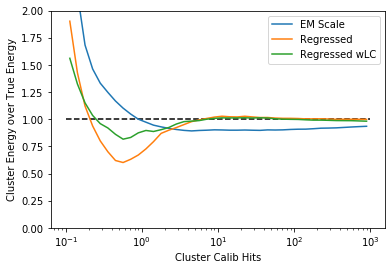

In [116]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0.1, 1000], [1, 1], linestyle='--',color='black')
plt.plot(xcenter, medBase, label = 'EM Scale')
plt.plot(xcenter, medReg, label = 'Regressed')
plt.plot(xcenter, medRegwLC, label = 'Regressed wLC')
plt.xscale('log')
plt.ylim(0,2)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Energy over True Energy')
plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_scale_pp_EMvsRegwLC.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

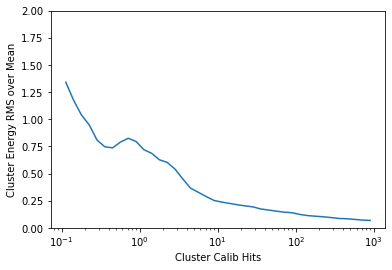

In [118]:
xcenter, iqrOverMedGRegwlc = ru.resolutionPlot(pp['cluster_ENG_CALIB_TOT'], 
                                                predict_base_wlc_pp/pp['cluster_ENG_CALIB_TOT'],
                                                plotpath+'ist_2D_calib_vs_baselineregwLCratio_pp_iqrMed', statistic='iqrOverMed')

<Figure size 432x288 with 0 Axes>

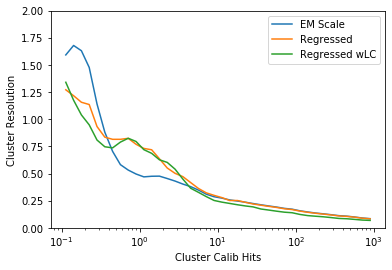

In [119]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(xcenter, iqrOverMedG, label = 'EM Scale')
plt.plot(xcenter, iqrOverMedGReg, label = 'Regressed')
plt.plot(xcenter, iqrOverMedGRegwlc, label = 'Regressed wLC')
plt.xscale('log')
plt.ylim(0,2)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Resolution')
plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_resolution_pp_EMvsRegwLC.pdf')
plt.show()

Better scale, and better resolution! Amazing. Should understand why near 1-5 GeV we get the bump in the resolution-- we do worse than EM scale